# MNIST Tensorflow 2.0 실습

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

In [3]:
(X,y) = datasets. load_digits(return_X_y=True)
X = X.astype(np.float32)
y = y.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.2, random_state=1)

# Hidden Layer 숫자를 지정

In [4]:
n_inputs = 64
n_hidden_1 = 25
n_hideen_2 = 25
n_outputs = 10

# 신경망 클래스 빌드

In [5]:
class NNLayer(object):
    def __init__(self, n_inputs, n_neurons, activation=None):
        init = tf.random.normal((n_inputs, n_neurons),
                               stddev=2 / np.sqrt(n_inputs))
        self.W = tf.Variable(init, name = 'kernel')
        self.b = tf.Variable(tf.zeros([n_neurons]), name='bias')
        self.activation = activation
        
    def __call__(self, X):
        Z = tf.matmul(X,self.W) + self.b
        if self.activation is not None:
            return self.activation(Z)
        else:
            return Z
        
    def trainable_variables(self):
        return [self.W, self.b]

In [6]:
class Model (object):
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def trainable_variables(self):
        variables= []
        for layer in self.layers:
            variables.extend(layer.trainable_variables())
        return variables

In [7]:
# Loss Function

loss_function = tf.nn.sparse_softmax_cross_entropy_with_logits

## Hidden Layers 만들기

In [8]:
model = Model([
    NNLayer(n_inputs, n_hidden_1, activation=tf.nn.relu),
    NNLayer(n_hidden_1, n_hideen_2, activation=tf.nn.relu),
    NNLayer(n_hideen_2, n_outputs)
])

In [9]:
def loss(model, X, y_true):
    y_pred = model(X)
    return tf.reduce_mean(tf.dtypes.cast(loss_function(labels=y_true, logits=y_pred),
                                       tf.float32, name='loss'))

In [10]:
l = loss(model, X_train, y_train)
print('Testing loss', l)

Testing loss tf.Tensor(49.72302, shape=(), dtype=float32)


In [11]:
# GD Background
def grad(model, X, y_true) :
    with tf.GradientTape() as tape :
        loss_value = loss(model, X, y_true)
    return loss_value, tape.gradient(loss_value, model.trainable_variables())

In [12]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [13]:
loss_value, grads = grad(model, X_train, y_train)
print('Step : {}, Initial loss: {}'.format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

Step : 0, Initial loss: 49.723018646240234


In [14]:
optimizer.apply_gradients(zip(grads, model.trainable_variables()))
print('Step : {}, Initial loss: {}'.format(optimizer.iterations.numpy(),
                                          loss(model, X_train, y_train).numpy()))

Step : 1, Initial loss: 46.77272415161133


## Epoch로 학습하기

In [15]:
train_loss_results=[]
train_accuracy_results=[]

epochs = 1000

for epoch in range(epochs) :
    
    loss_value, grads = grad(model, X_train, y_train)
    optimizer.apply_gradients(zip(grads, model.trainable_variables()))
    
    y_pred = model(X_train)
    correct = tf.equal(tf.math.argmax(y_pred, axis=1), y_train)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    train_loss_results.append(loss_value.numpy())
    train_accuracy_results.append(accuracy)
    
    if epoch % 10 == 0:
        print('Epoch {:03d}: Loss : {:1.3%}, accuracy : {:1.3%}'.format(epoch,
                                                   loss_value.numpy(),
                                                   accuracy))

Epoch 000: Loss : 4677.272%, accuracy : 11.413%
Epoch 010: Loss : 2769.223%, accuracy : 16.354%
Epoch 020: Loss : 1839.864%, accuracy : 24.078%
Epoch 030: Loss : 1279.986%, accuracy : 29.923%
Epoch 040: Loss : 915.099%, accuracy : 34.656%
Epoch 050: Loss : 666.122%, accuracy : 38.761%
Epoch 060: Loss : 510.463%, accuracy : 45.303%
Epoch 070: Loss : 410.176%, accuracy : 50.661%
Epoch 080: Loss : 338.954%, accuracy : 54.628%
Epoch 090: Loss : 285.941%, accuracy : 58.177%
Epoch 100: Loss : 245.298%, accuracy : 61.795%
Epoch 110: Loss : 213.530%, accuracy : 66.180%
Epoch 120: Loss : 188.484%, accuracy : 69.381%
Epoch 130: Loss : 168.072%, accuracy : 72.651%
Epoch 140: Loss : 150.653%, accuracy : 74.878%
Epoch 150: Loss : 136.604%, accuracy : 77.105%
Epoch 160: Loss : 125.094%, accuracy : 78.566%
Epoch 170: Loss : 115.380%, accuracy : 79.889%
Epoch 180: Loss : 106.981%, accuracy : 81.280%
Epoch 190: Loss : 99.320%, accuracy : 81.976%
Epoch 200: Loss : 92.101%, accuracy : 82.463%
Epoch 210: 

## MNIST Tensorflow 실습2

In [16]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

In [17]:
X_train = X_train / 255.0
y_train = y_train / 255.0

In [18]:
def my_model() :
    inputs = Input(shape=(64,))
    
    #keras feature - model.add () can add sequential 
    x = Dense(128, activation='relu')(inputs)
    x =  Dense(128, activation='relu')(inputs)
    x = Dense(10, activation='softmax')(inputs)
    
    model = Model(inputs = inputs, outputs = x)
    return model
model = my_model()

In [19]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

loss_object = SparseCategoricalCrossentropy()
optimizer = Adam()

In [20]:
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

train_loss = Accuracy(name='train_loss')
train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')

In [21]:
@tf.function
def train_step(images, labels) :
    with tf.GradientTape as tape :
        outputs = model(images, training=True)
        loss = loss_object(labels, outputs)
    gradients = tape.gradient(loss, model.trainable_variables) 
    optimizer.apply_gradient(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, outputs)

In [22]:
Epochs = 20

for i in range(Epochs) :
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for images, labels in X_train :
        train_step(images, labels)
    print('Epochs : {}, train_loss : {}, train_acc : {}'.format(i+1, train_loss.result(), train_accuracy.result() * 100))

ValueError: too many values to unpack (expected 2)

In [ ]:
pwd

# CNN-cifa10

## 데이터 불러오기

In [23]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


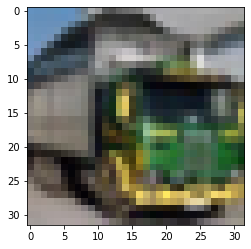

In [25]:
import matplotlib.pyplot as plt

plt.imshow(X_train[14])
plt.show()

In [26]:
X_train = X_train / 255.0
y_train = y_train / 255.0

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
3c차원 conviltion 2d 

In [31]:
#1
model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    #Maxpool2D(pool_size=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
    
])

In [33]:
model.compile(optimizers=Adam,
             loss= 'sparse_categorical_crossentropy',
            metrics=['accuracy'])
history = model.fit(X_train, y_train,
                   epochs=5,
                   batch_size=30)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 140s 3ms/sample - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 2/5
50000/50000 [==============================] - 126s 3ms/sample - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 3/5
50000/50000 [==============================] - 122s 2ms/sample - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 4/5
50000/50000 [==============================] - 125s 3ms/sample - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 5/5
50000/50000 [==============================] - 122s 2ms/sample - loss: 0.0000e+00 - accuracy: 0.1000


In [34]:
model.evaluate(X_test, y_test, verbose=2)

10000/1 - 5s - loss: 21100.5862 - accuracy: 0.1000


[20654.66456875, 0.1]

In [35]:
#2
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), padding='same'),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), padding='same'),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    #Maxpool2D(pool_size=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
    
])

In [36]:
model.compile(optimizers=Adam(0.0001),
             loss= 'sparse_categorical_crossentropy',
              mertics=['acc'])
history = model.fit(X_train, y_train,
                   epochs=5, batch_size=32,
                   validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 130s 3ms/sample - loss: 0.0019 - val_loss: 0.0000e+00
Epoch 2/5
40000/40000 [==============================] - 128s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
40000/40000 [==============================] - 121s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/5
40000/40000 [==============================] - 125s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
40000/40000 [==============================] - 123s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00


In [34]:
model.evaluate(X_test, y_test, verbose=2)

10000/1 - 5s - loss: 21100.5862 - accuracy: 0.1000


[20654.66456875, 0.1]

In [ ]:
#3
model = Sequential([
    Conv2D(filters=32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
     MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Conv2D(filters=32, 3, padding='same',, activation='relu'),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
    #Maxpool2D(pool_size=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
    
])

In [ ]:
model.compile(optimizers=Adam(0.0001),
             loss= 'sparse_categorical_crossentropy',
              mertics=['acc'])
history = model.fit(X_train, y_train,
                   epochs=5, batch_size=32,
                   validation_split=0.2)

In [34]:
model.evaluate(X_test, y_test, verbose=2)

10000/1 - 5s - loss: 21100.5862 - accuracy: 0.1000


[20654.66456875, 0.1]

In [ ]:
#4
model = Sequential([
    Conv2D(filters=32, 3, padding='same', activation='relu', input_shape=(32,32,3)),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0,2),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
     MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
    Dropout(0,2),
    Conv2D(filters=32, 3, padding='same',, activation='relu'),
    Conv2D(filters=32, 3, padding='same', activation='relu'),
    #Maxpool2D(pool_size=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
    
])

In [ ]:
loss, acc = model.evaluate(X_train, y_train, verbose=2)
print('정확도:{:5.2f}%'.format(acc*100))

In [ ]:
model.compile(optimizers=Adam(0.0001),
             loss= 'sparse_categorical_crossentropy',
              mertics=['acc'])
history = model.fit(X_train, y_train,
                   epochs=5, batch_size=32,
                   validation_split=0.2)

In [ ]:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896   = 30*30*32    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32) : 필터수 만큼        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 128)         147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         : 마지막에 flatten해서 일렬로 
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
================================================================= 필터마다 가중치와bias 가 다름
Total params: 322,602
Trainable params: 322,602
Non-trainable params: 0
채널마다 가중치가 다른데 (in convolution)
각각 뽑아낸 값을 더해서 + (in Feature)
결국 각 convolutional layer 에서 각 feature 를 다 가져간다(끝에서 다 더하니까 누적되는 것)

CNN parameters
Hyper parameters = 필터의 수 K
필터의 크기 False스트라이드 S
패딩 P
크기를 잘 봐야 함
( None, 12, 12, 64) → (None, 10, 10, 64) : MaxPool2D을 기준으로 줄어든다. 조절을 Maxpool을 보고 다음 filter 수를 조절할 것

Reset50

Transfer Learning = 전이학습
마지막 Flatten한 상태에서 기존의 원본 flatten 학습 -> 정확도를 더 높임